Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
W0 shape: (3072, 100)
b0 shape: (1, 100)
W1 shape: (100, 30)
b1 shape: (1, 30)
W2 shape: (30, 10)
b2 shape: (1, 10)
iteration 0 / 25000: loss 2.302574
epoch done... acc 0.078
iteration 100 / 25000: loss 2.302581
iteration 200 / 25000: loss 2.302580
iteration 300 / 25000: loss 2.302576
iteration 400 / 25000: loss 2.302509
epoch done... acc 0.148
iteration 500 / 25000: loss 2.302314
iteration 600 / 25000: loss 2.300538
iteration 700 / 25000: loss 2.296742
iteration 800 / 25000: loss 2.278284
iteration 900 / 25000: loss 2.273488
epoch done... acc 0.153
iteration 1000 / 25000: loss 2.223482
iteration 1100 / 25000: loss 2.188504
iteration 1200 / 25000: loss 2.169504
iteration 1300 / 25000: loss 2.124668
iteration 1400 / 25000: loss 2.125776
epoch done... acc 0.182
iteration 1500 / 25000: loss 2.039790
iteration 1600 / 25000: loss 2.088755
iteration 1700 / 250

iteration 18400 / 25000: loss 1.812318
iteration 18500 / 25000: loss 1.631260
iteration 18600 / 25000: loss 1.838924
epoch done... acc 0.373
iteration 18700 / 25000: loss 1.782312
iteration 18800 / 25000: loss 1.824463
iteration 18900 / 25000: loss 1.757895
iteration 19000 / 25000: loss 1.839281
iteration 19100 / 25000: loss 1.821811
epoch done... acc 0.378
iteration 19200 / 25000: loss 1.678333
iteration 19300 / 25000: loss 1.770238
iteration 19400 / 25000: loss 1.740421
iteration 19500 / 25000: loss 1.809471
iteration 19600 / 25000: loss 1.846559
epoch done... acc 0.376
iteration 19700 / 25000: loss 1.605112
iteration 19800 / 25000: loss 1.810425
iteration 19900 / 25000: loss 1.767975
iteration 20000 / 25000: loss 1.621152
epoch done... acc 0.374
iteration 20100 / 25000: loss 1.595712
iteration 20200 / 25000: loss 1.774620
iteration 20300 / 25000: loss 1.697041
iteration 20400 / 25000: loss 1.736182
iteration 20500 / 25000: loss 1.535557
epoch done... acc 0.378
iteration 20600 / 2500

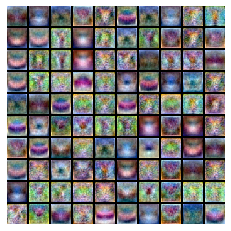

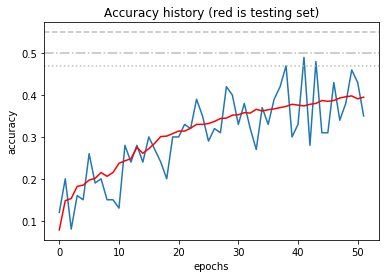

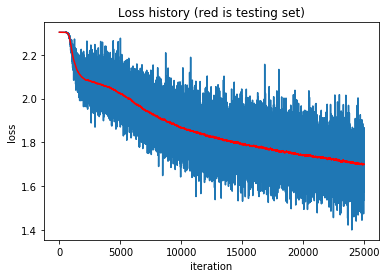

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import helper
import os
import random

# show plot first run
%matplotlib inline 
# test autocompletion with tab or tab+shift
%config IPCompleter.greedy=True 

random.seed(30)

class TwoLayerNeuralNetwork:
    """
    Ein 2-Layer 'fully-connected' neural network, d.h. alle Neuronen sind mit allen anderen
    verbunden. Die Anzahl der Eingabevektoren ist N mit einer Dimension D, einem 'Hidden'-Layer mit
    H Neuronen. Es soll eine Klassifikation über 10 Klassen (C) durchgeführt werden.
    Wir trainieren das Netzwerk mit einer 'Softmax'-Loss Funktion und einer L2 Regularisierung
    auf den Gewichtungsmatrizen (W1 und W2). Das Netzwerk nutzt ReLU Aktivierungsfunktionen nach
    dem ersten Layer.
    Die Architektur des Netzwerkes läßt sich abstrakt so darstellen:
    Eingabe - 'fully connected'-Layer - ReLU - 'fully connected'-Layer - Softmax

    Die Ausgabe aus dem 2.Layer sind die 'Scores' (Wahrscheinlichkeiten) für jede Klasse.
    """

    def __init__(self, input_size, hidden_size0, hidden_size1, output_size, std=1e-4):
        """
        Intitialisierung des Netzes - Die Gewichtungsmatrizen und die Bias-Vektoren werden mit
        Zufallswerten initialisiert.
        W1: 1.Layer Gewichte (D, H)
        b1: 1.Layer Bias (H,)
        W2: 2.Layer Gewichte (H, C)
        b2: 2.Layer Bias (C,)

        :param input_size: Die CIFAR-10 Bilder haben die Dimension D (32*32*3).
        :param hidden_size: Anzahl der Neuronen im Hidden-Layer H.
        :param output_size: Anzahl der Klassen C.
        :param std: Skalierungsfaktoren für die Initialisierung (muss klein sein)
        :return:
        """
        
        self.W0 = std * np.random.randn(input_size, hidden_size0)
        self.b0 = std * np.random.randn(1, hidden_size0)
        self.W1 = std * np.random.randn(hidden_size0, hidden_size1)
        #self.W1 = std * np.random.randn(input_size, hidden_size1)
        self.b1 = std * np.random.randn(1, hidden_size1)
        self.W2 = std * np.random.randn(hidden_size1, output_size)
        self.b2 = std * np.random.randn(1, output_size)
        print('W0 shape:', self.W0.shape)
        print('b0 shape:', self.b0.shape)
        print('W1 shape:', self.W1.shape)
        print('b1 shape:', self.b1.shape)
        print('W2 shape:', self.W2.shape)
        print('b2 shape:', self.b2.shape)

    def softmax(self, z):
        z -= np.max(z)
        return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

    def relu(self, x):
        return np.maximum(0.0, x)

    def relu_derivative(self, output):
        output[output <= 0] = 0
        output[output>0] = 1
        return output

    def loss_deriv_softmax(self, activation, y_batch):
        batch_size = y_batch.shape[0]
        dCda2 = activation
        dCda2[range(batch_size), y_batch] -= 1
        dCda2 /= batch_size
        return dCda2

    def loss_crossentropy(self, activation, y_batch):
        """
        Berechnet den loss (Fehler) des 2-Layer-Netzes

        :param batch_size: Anzahl der Eingabebilder in einem Batch über den der Fehler normalisiert werden muss
        :param y: Vektor mit den Trainingslabels y[i] enthält ein Label aus X[i] und jedes y[i] ist ein
                  Integer zwischen 0 <= y[i] < C (Anzahl der Klassen)
        :param reg: Regulasierungsstärke
        :return: loss - normalisierter Fehler des Batches
        """

        batch_size = y_batch.shape[0]
        correct_logprobs = -np.log(activation[range(batch_size), y_batch])
        loss = np.sum(correct_logprobs) / batch_size
        return loss


    def forward(self, X, y):
        """
        Führt den gesamten Forward Prozess durch und berechnet den Fehler (loss) und die Aktivierungen a1 und
        a2 und gibt diese Werte zuruück
        :param X: Trainings bzw. Testset
        :param y: Labels des Trainings- bzw. Testsets
        :return: loss, a1, a2
        """

        # Berechen Sie den score
        #N, D = X.shape
        # TODO: Berechnen Sie den Forward-Schritt und geben Sie den Vektor mit Scores zurueck
        # Nutzen Sie die ReLU Aktivierungsfunktion im ersten Layer
        # Berechnen Sie die Klassenwahrscheinlichkeiten unter Nutzung der softmax Funktion
        m0 = (X @ self.W0) + self.b0
        #print('forward m0.shape:',m0.shape)
        a0 = self.relu(m0)
        
        m1 = (a0 @ self.W1) + self.b1
        #print('forward m1.shape:',m1.shape)
        a1 = self.relu(m1)
        
        m2 = (a1 @ self.W2) + self.b2
        #print('forward m2.shape:',m2.shape)
        a2 = self.softmax(m2)
        
        # TODO: Berechnen Sie den Fehler mit der cross-entropy Funktion
        loss = self.loss_crossentropy(a2, y)
        
        return loss, a0, a1, a2

    def backward(self, a0, a1, a2, X, y):
        """
        Backward pass- dabei wird der Gradient der Gewichte W0, W1, W2 und der Biases b0, b1, b2 aus den 
        Ausgaben des Netzes berechnet und die Gradienten der einzelnen Layer als ein Dictionary zurückgegeben.
        Zum Beispiel sollte grads['W0'] die Gradienten von self.W0 enthalten 
        (das ist eine Matrix der gleichen Größe wie self.W0.)
        :param a0: Aktivierung aus dem 1.Layer
        :param a1: Aktivierung aus dem 1.Layer
        :param a2: Aktivierung aus dem 2.Layer -> Output des Netzes
        :param X:
        :param y:
        :return:
        """
        # Nutzen Sie dabei die Notizen aus der Vorlesung und die gegebenen Ableitungsfunktionen
        # please use the appropriate loss functions 
        # YOUR CODE HERE
        # Backward pass: Berechnen Sie die Gradienten
        #N, D = X.shape
        
        # W1' = X.T * ( ( (2*(a2-yc)*relu(a2)) * W2.T ) * relu(a1) ) ## use relu(a2) or not??? no neg val can pass through
        # b1' = 1 * ( ( (2*(a2-yc)*relu(a2)) * W2.T ) * relu(a1) )
        # W2' = a1.T * 2*(a2 - yc)
        # v2' = 1 * 2*(a2 - yc)

        # activations reverse
        dCda2  = self.loss_deriv_softmax(a2,y) # for W2
        da1dm1 = self.relu_derivative(a1) #for W1
        da0dm0 = self.relu_derivative(a0) # for W0
        
        # implementation
        tmp2 = dCda2 @ self.W2.T
        tmp3 = tmp2 * da1dm1 # *relu_deriv element wise mult
       
        tmp4 = tmp3 @ self.W1.T
        tmp5 = tmp4 * da0dm0 # *relu_deriv element wise mult
    
    
    
        dCdW2 = a1.T @ dCda2
        dCdb2 = np.mean( dCda2, axis=0 )
    
        dCdW1 = a0.T @ tmp3
        dCdb1 = np.mean( tmp3, axis=0 )

        dCdW0 = X.T @ tmp5
        dCdb0 = np.mean( tmp5, axis=0 )

        # function should return 4 derivatives with respect to
        # W1, W2, b1, b2        
        # Füllen Sie das Dictionary grads['W2'], grads['b2'], grads['W1'], grads['b1']
        grads = {}
        grads['W0'] = dCdW0
        grads['b0'] = dCdb0
        grads['W1'] = dCdW1
        grads['b1'] = dCdb1
        grads['W2'] = dCdW2
        grads['b2'] = dCdb2
        
        return grads
        
    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95, num_iters=100,
              batch_size=200, verbose=False):
        """
        Training des Neuronalen Netzwerkes unter der Nutzung des iterativen
        Optimierungsverfahrens Stochastic Gradient Descent
        Train this neural network using stochastic gradient descent.

        :param X: Numpy Array der Größe (N,D)
        :param y: Numpy Array der Größe (N,) mit den jeweiligen Labels y[i] = c. Das bedeutet, dass X[i] das label c hat
                  mit 0 <= c < C
        :param X_val: Numpy Array der Größe (N_val,D) mit den Validierungs-/Testdaten
        :param y_val: Numpy Array der Größe (N_val,) mit den Labels für die Validierungs-/Testdaten
        :param learning_rate: Faktor der Lernrate für den Optimierungsprozess
        :param learning_rate_decay: gibt an, inwieweit die Lernrate in jeder Epoche angepasst werden soll
        :param reg: Stärke der Regularisierung
        :param num_iters: Anzahl der Iterationen der Optimierung
        :param batch_size: Anzahl der Trainingseingabebilder, die in jedem forward-Schritt mitgegeben werden sollen
        :param verbose: boolean, ob etwas ausgegeben werden soll
        :return: dict (fuer die Auswertung) - enthält Fehler und Genauigkeit der Klassifizierung für jede Iteration bzw. Epoche
        """
        num_train = X.shape[0]
        iterations_per_epoch = int(max(num_train / batch_size, 1))

        # Wir nutzen einen Stochastischen Gradient Decent (SGD) Optimierer um unsere
        # Parameter W1,W2,b1,b2 zu optimieren
        loss_history = []
        loss_val_history = []
        train_acc_history = []
        val_acc_history = []

        sample_propabilities = np.ones(X.shape[0])
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            ############################
            # TODO: Erzeugen Sie einen zufälligen Batch der Größe batch_size
            # aus den Trainingsdaten und speichern diese in X_batch und y_batch
            # X_batch
            # y_batch 
            idx = random.sample(range(0, num_train), batch_size)
            X_batch = X[idx]
            y_batch = y[idx]
            
            ############################

            # TODO: Berechnung von loss und gradient für den aktuellen Batch
            #print('X_batch shape:',X_batch.shape)
            #print('y_batch shape:',y_batch.shape)
            loss, a0, a1, a2 = self.forward(X_batch, y_batch)
            # Merken des Fehlers für den Plot
            loss_history.append(loss)
            
            # Jetzt backward pass (Gradienten berechnen).
            # backward pass 
            grads = self.backward(a0, a1, a2, X_batch, y_batch)
            
            # Berechnung des Fehlers mit den aktuellen Parametern (W, b)
            # mit dem Testset
            loss_val, a0_val, a1_val, a2_val = self.forward(X_val, y_val)
            loss_val_history.append(loss_val)

            ############################
            # TODO: Nutzen Sie die Gradienten aus der Backward-Funktion und passen
            # Sie die Parameter an (self.W1, self.b1 etc). Diese werden mit der Lernrate
            # gewichtet
            self.W0 -= learning_rate * grads['W0']
            self.b0 -= learning_rate * grads['b0']
            self.W1 -= learning_rate * grads['W1']
            self.b1 -= learning_rate * grads['b1']
            self.W2 -= learning_rate * grads['W2']
            self.b2 -= learning_rate * grads['b2']
            
            ############################

            # Ausgabe des aktuellen Fehlers. Diese sollte am Anfang erstmal nach unten gehen
            # kann aber immer etwas schwanken.
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Wir überprüfen jede Epoche die Genauigkeit (von Trainingsset und Testset)
            # und dämpfen die Lernrate
            if it % iterations_per_epoch == 0:
                # Überprüfung der Klassifikationsgenauigkeit
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                print('epoch done... acc', val_acc)

                # Dämpfung der Lernrate
                learning_rate *= learning_rate_decay

        # Zum Plotten der Genauigkeiten geben wir die
        # gesammelten Daten zurück
        return {
            'loss_history': loss_history,
            'loss_val_history': loss_val_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Benutzen Sie die trainierten Gewichte des 2-Layer-Netzes um die Klassen für das
        Validierungsset vorherzusagen. Dafür müssen Sie für das/die Eingabebilder X nur
        die Scores berechnen. Der höchste Score ist die vorhergesagte Klasse. Dieser wird in y_pred
        geschrieben und zurückgegeben.

        :param X: Numpy Array der Größe (N,D)
        :return: y_pred Numpy Array der Größe (N,) die die jeweiligen Labels für alle Elemente in X enthaelt.
        y_pred[i] = c bedeutet, das fuer X[i] die Klasse c mit 0<=c<C vorhergesagt wurde
        """
        m0 = (X @ self.W0) + self.b0
        a0 = self.relu(m0)

        m1 = (a0 @ self.W1) + self.b1
        a1 = self.relu(m1)
        
        a2 = (a1 @ self.W2) + self.b2
        #print('forward m2.shape:',m2.shape)
        #a2 = self.softmax(m2)
        
        ############################
        # TODO: Implementieren Sie die Vorhersage. D.h. für ein/mehrere Bild/er mit den gelernten
        # Parametern den Wahrscheinlichkeit berechnen.
        # np.argmax in dem Wahrscheinlichkeitsvektor ist die wahrscheinlichste Klasse
        ############################
        # Implementieren Sie nochmals den Forward pass um die Wahrscheinlichkeiten
        # vorherzusagen
        y_pred = np.argmax(a2, axis=1)
        #print('y_pred:',y_pred)
        return y_pred


if __name__ == '__main__':
    X_train, y_train, X_val, y_val = helper.prepare_CIFAR10_images()
    # TODO: Laden der Bilder. Hinweis - wir nutzen nur die Trainigsbilder zum Trainieren und die
    # Validierungsbilder zum Testen.
    print('Train data shape: ', X_train.shape)
    print('Train labels shape: ', y_train.shape)
    print('Validation data shape: ', X_val.shape)
    print('Validation labels shape: ', y_val.shape)

    # Grösse der Bilder
    input_size = 32 * 32 * 3
    # Anzahl der Klassen
    num_classes = 10

    #############################################
    # Hyperparameter0    ##1###########################################1


    # TODO: mit diesen Parametern sollten Sie in etwa auf eine
    # Klassifikationsgenauigkeit von 43% kommen. Optimieren Sie die
    # Hyperparameter um die Genauigkeit zu erhöhen (bitte tun sie das
    # systematisch und nicht einfach durch probieren - also z.B. in einem
    # for-loop eine Reihe von Parametern testen und die Einzelbilder abspeichern)
    
    hidden_size0 = 100   # Anzahl der Neuronen im Hidden Layer
    hidden_size1 = 30   # Anzahl der Neuronen im Hidden Layer
    num_iter = 25000  # Anzahl der Optimierungsiterationen
    batch_size = 100  # Eingabeanzahl der Bilder
    learning_rate = 0.001  # Lernrate
    learning_rate_decay = 0.99  # Lernratenabschwächung
    
    net = TwoLayerNeuralNetwork(input_size, hidden_size0,hidden_size1, num_classes)

    # Train the network
    stats = net.train(X_train, y_train, X_val, y_val,
                        learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, 
                      num_iters=num_iter, batch_size=batch_size, verbose=True)

    print('Final training loss: ', stats['loss_history'][-1])
    print('Final validation loss: ', stats['loss_val_history'][-1])

    print('Final validation accuracy: ', stats['val_acc_history'][-1])

    helper.plot_net_weights(net)
    helper.plot_accuracy(stats)
    helper.plot_loss(stats)
